<a href="https://colab.research.google.com/github/Stelath/pytorch-learning/blob/main/Pytorch_Learning_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get Dataset

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

--2021-12-03 00:16:57--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.73.0.105, 2600:1409:9800:686::e59, 2600:1409:9800:693::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.73.0.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip.3’

kagglecatsanddogs_3 100%[===================>] 786.68M   167MB/s    in 4.7s    

2021-12-03 00:17:02 (167 MB/s) - ‘kagglecatsanddogs_3367a.zip.3’ saved [824894548/824894548]



In [ ]:
!unzip kagglecatsanddogs_3367a.zip

Archive:  kagglecatsanddogs_3367a.zip
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Import Librarys

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

Import Dataset

In [ ]:
REBUILD_DATA = False

class DogsVSCats():
  IMG_SIZE = 50
  CATS = 'PetImages/Cat'
  DOGS = 'PetImages/Dog'
  LABELS = {CATS: 0, DOGS: 1}
  training_data = []
  cat_count = 0
  dog_count = 0

  def make_training_data(self):
    for label in self.LABELS:
      print(label)
      for f in tqdm(os.listdir(label)):
        try:
          path = os.path.join(label, f)
          img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
          self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

          if label == self.CATS:
            self.cat_count += 1
          elif label == self.DOGS:
            self.dog_count += 1
        except Exception as e:
          pass
          # print(str(e))
    
    np.random.shuffle(self.training_data)
    np.save('training_data.npy', self.training_data)
    print()
    print('Cats:', self.cat_count)
    print('Dogs:', self.dog_count)

if REBUILD_DATA:
  dogvcats = DogsVSCats()
  dogvcats.make_training_data()


In [ ]:
training_data = np.load('training_data.npy', allow_pickle=True)
print(len(training_data))
print(training_data[0])

24946
[array([[ 37,  80, 102, ..., 119, 119, 129],
       [ 64,  94, 102, ..., 102, 113, 123],
       [ 64,  71,  71, ..., 103, 106, 124],
       ...,
       [114, 111, 112, ..., 149, 167, 170],
       [116, 114, 112, ..., 160, 166, 171],
       [117, 121, 118, ..., 168, 157, 162]], dtype=uint8)
 array([0., 1.])]


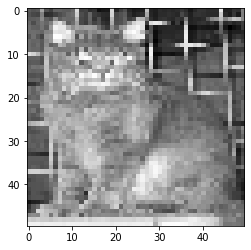

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap='gray')
plt.show()

In [ ]:
training_data[1][1]

array([1., 0.])

Build Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.conv3 = nn.Conv2d(64, 128, 5)

    x = torch.randn(50, 50).view(-1, 1, 50, 50)
    self._to_linear = None
    self.convs(x)

    self.fc1 = nn.Linear(self._to_linear, 512)
    self.fc2 = nn.Linear(512, 2)

  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
    
    if self._to_linear is None:
      self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
    
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    # Use activation function cause its probably better
    return F.softmax(x, dim = 1)

net = Net()

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
print(val_size)

2494


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [ ]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [ ]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
  for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
    batch_X = train_X[i:i + BATCH_SIZE].view(-1, 1, 50, 50)
    batch_y = train_y[i:i + BATCH_SIZE]

    net.zero_grad()
    outputs = net(batch_X)
    loss = loss_function(outputs, batch_y)
    loss.backward()
    optimizer.step()

print(loss)
    

  0%|          | 0/225 [00:00<?, ?it/s]

tensor(0.2113, grad_fn=<MseLossBackward0>)


In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for i in tqdm(range(len(test_X))):
    real_class = torch.argmax(test_y[i])
    net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
    predicted_class = torch.argmax(net_out)
    if predicted_class == real_class:
      correct += 1
    total += 1

print()
print('Accuracy:', round(correct / total, 3))

100%|██████████| 2494/2494 [00:07<00:00, 328.07it/s]


Accuracy: 0.63
